_version log: improving the angle measurements for boardband_

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
import os
import re
from scipy import interpolate
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size':14})

pixel_pitch = 9.9 #um
c = 299_792_458

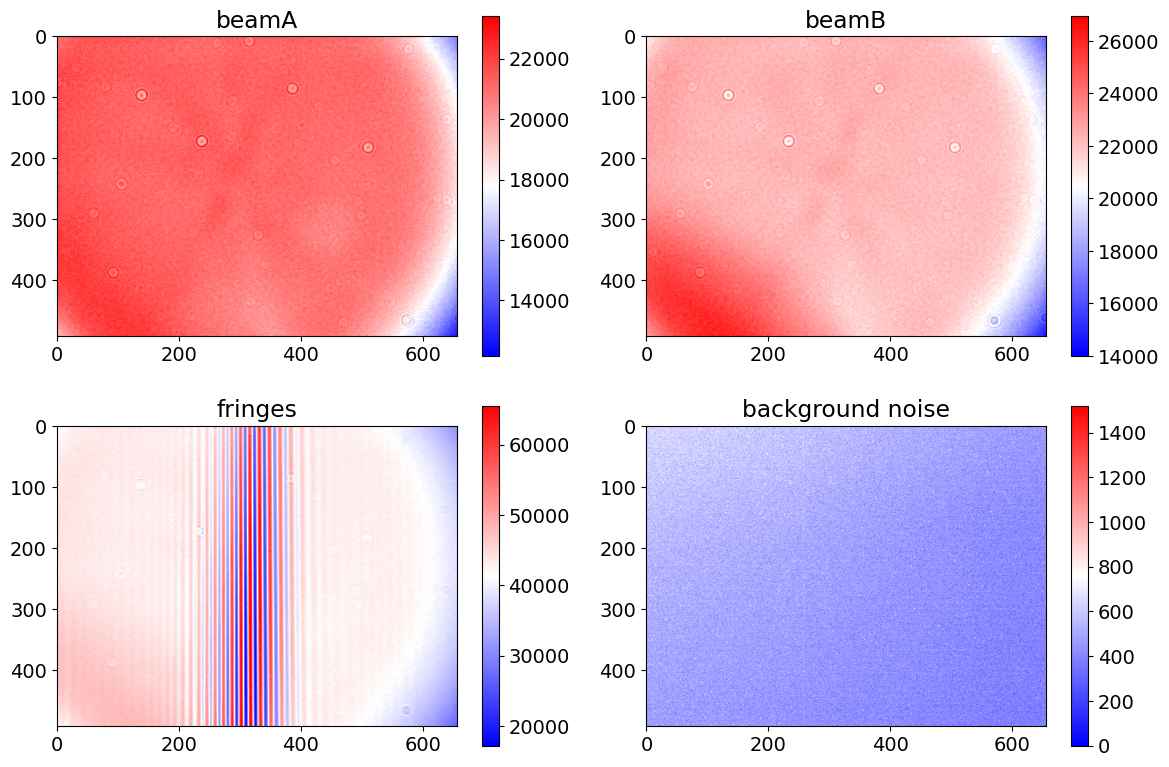

In [14]:
def import_standard_tif(colour, number):
    im = Image.open('data\\'+colour+'_fringes'+number+'.tif')
    fringes = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_BA'+number+'.tif')
    beamA = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_BB'+number+'.tif')
    beamB = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_bg'+number+'.tif')
    background = np.array(im, dtype= np.float32)
    return fringes, beamA, beamB, background

fringes, beamA, beamB, background = import_standard_tif("ir", "9")

plt.figure(figsize= (12,8))

plt.subplot(2,2,1)
im=plt.imshow(beamA, cmap='bwr')
plt.colorbar(im)
plt.title("beamA")

plt.subplot(2,2,2)
im=plt.imshow(beamB, cmap='bwr')
plt.colorbar(im)
plt.title("beamB")

plt.subplot(2,2,3)
im=plt.imshow(fringes, cmap='bwr')
plt.colorbar(im)
plt.title("fringes")

plt.subplot(2,2,4)
im=plt.imshow(background, cmap='bwr')
plt.colorbar(im)
plt.title("background noise")

plt.tight_layout()
plt.show()

In [15]:
def find_angle_files(colour, number):
    file_names = os.listdir("data\\")
    new_file_names=[]
    new_file_numbers=[]

    for file_name in file_names:
        check = re.findall(colour+'_fringes'+number+'_[0-9]+.tif' , file_name)
        if len(check) != 0:
            new_file_names = new_file_names + [file_name]

            file_number = re.findall('[0-9]+' , file_name)
            new_file_numbers = new_file_numbers + [int(file_number[-1]) -1] #the number that we are looking for is always the last number in the file name

    df = pd.DataFrame(np.transpose([new_file_names, new_file_numbers]), columns= ["file names", "file numbers"])
    df["file numbers"] = [int(number) for number in df["file numbers"]] #pandas forgot that numbers are intergers
    df = df.sort_values("file numbers", ignore_index= True) #I still don't know how to sort values using a key with numpy

    return df["file names"], df["file numbers"]

file_names, file_numbers = find_angle_files("ir", "9")

def combine_angle_arrays(file_names):

    im = Image.open('data\\'+file_names[0]) #for the first interferogram
    angles = np.array(im, dtype= np.float32)

    for file_name in file_names[1:]: #for every other interferogram
        im = Image.open('data\\'+file_name)
        Array = np.array(im, dtype= np.float32)
        angles = np.dstack([angles,Array])

    return angles

angles = combine_angle_arrays(file_names)

In [16]:
def process_fringes(fringes, beamA, beamB, background):

    try:
        nofringes = np.dstack([beamA +beamB -background] *fringes.shape[2]) #This will throw an error if fringes is 2d
    except IndexError:
        nofringes = beamA +beamB -background #ignore the error

    if False: #toggle which meathod you want to use. IDK which one is better.
        beamPost = fringes - nofringes #take away background. This meathod exaggerates the bandwidth.
    else:
        beamPost = fringes / nofringes #normalise using background. This meathod suffers with div0 errors and exaggerates the noise.
        beamPost = np.nan_to_num(beamPost, #This is unphysical but so is infinate intensity.
                                posinf= np.nanmax(beamPost[np.isfinite(beamPost)]), #occors for x/0
                                neginf= np.nanmin(beamPost[np.isfinite(beamPost)]), #occors for -x/0. this should be impossible
                                nan= 0) #occors for 0/0
        
    return beamPost, nofringes

angles, _ = process_fringes(angles, beamA, beamB, background)


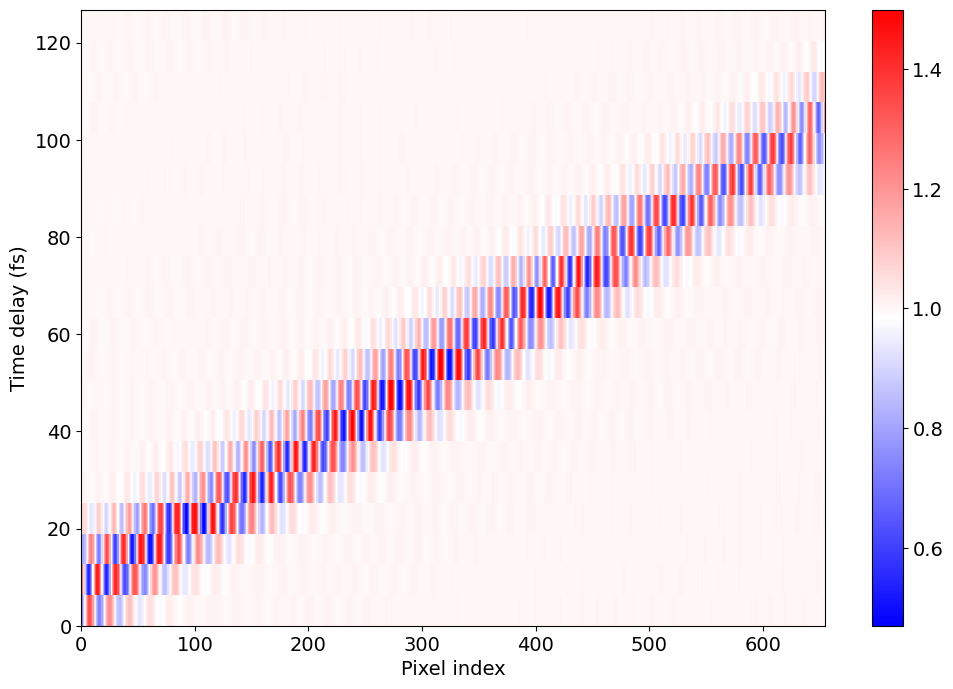

In [17]:
ROI = [[0,491],[0,655]] #region of interest in rows, columns. [[0,491],[0,655]]
delay_line_delta = 1 #um. Distance traveled by delay line between each reading
angle_averages = np.mean(angles[ROI[0][0]:ROI[0][1], ROI[1][0]:ROI[1][1]], axis = 0)

delay_line_travel = np.arange(angle_averages.shape[1]) *delay_line_delta
time_delay = delay_line_travel *2 /c
time_delay *= 1e9 #convert from us to fs

plt.figure(figsize = (12,8))

ax = plt.subplot(1,1,1)
im=plt.imshow(np.transpose(angle_averages), 
            cmap='bwr', 
            aspect = "auto", 
            interpolation = "none", #"none" and "nearest" are the only physical ones
            origin = "lower", 
            extent=[0,angle_averages.shape[0],0,time_delay[-1]])
plt.colorbar(im)
plt.xlabel("Pixel index")
plt.ylabel("Time delay (fs)")

plt.show()

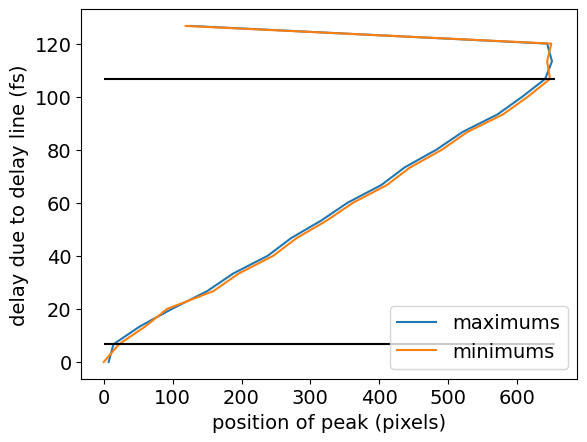

In [18]:
delay_line_bounds = [1,-4] #As the fringes move outside of the ROI, the peak position becomes inaccurate.

angle_maximums = np.argmax(angle_averages, axis = 0)
angle_minimums = np.argmin(angle_averages, axis = 0)

plt.plot(angle_maximums,
        time_delay,
        label = "maximums")
plt.plot(angle_minimums,
        time_delay,
        label = "minimums")

plt.hlines([time_delay[delay_line_bounds[0]],time_delay[delay_line_bounds[1]]], ROI[1][0], ROI[1][1], color = "k")
plt.ylabel('delay due to delay line (fs)')
plt.xlabel('position of peak (pixels)')
plt.legend()

plt.show()


In [20]:
def line(x,m,k):
    return m*x+k

popt, pcov = curve_fit(line, angle_maximums[delay_line_bounds[0]:delay_line_bounds[1]], time_delay[delay_line_bounds[0]:delay_line_bounds[1]] )
m = popt[0]
k = popt[1]
err_m = np.sqrt(pcov[0][0]) /m #make into percentage error
err_k = np.sqrt(pcov[1][1]) /k

print("gradient = {0:.2e} +/- {1:.1e} ".format(m, err_m*m) + "fs/pixel")

m /= 1e9 *pixel_pitch #convert the gradient from fs/pixel to um/us (= m/s)
theta = np.arcsin(c *m /2 ) 
theta *= 180/np.pi #convert from radians to degrees
err_theta = theta *err_m #relies on the small angle appoximation
print("angle between beams = {0:.3f} +/- {1:.3f}° or {2:.1f} +/- {3:.1f} arcminutes".format(2*theta, 2*err_theta, 60*2*theta, 60*2*err_theta))

gradient = 1.57e-01 +/- 1.0e-03 fs/pixel
angle between beams = 0.273 +/- 0.002° or 16.4 +/- 0.1 arcminutes
